In [1]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-09-15 11:50:27.352848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [2]:
adata = sc.read("../../data/adata_pancreas_2019_endocrine.h5ad")
sc.pp.pca(adata, n_comps=30)

In [3]:
n_cells_source=len(adata[adata.obs["day"]=="14.5"])
n_cells_target=len(adata[adata.obs["day"]=="15.5"])

n_samples_train_source = int(n_cells_source * 0.6)
n_samples_test_source = n_cells_source - n_samples_train_source

n_samples_train_target = int(n_cells_target * 0.6)
n_samples_test_target = n_cells_target - n_samples_train_target

inds_source_train = np.asarray(jax.random.choice(jax.random.PRNGKey(0), n_cells_source, (n_samples_train_source,), replace=False))
inds_source_test = list(set(list(range(n_samples_train_source))) - set(inds_source_train))

inds_target_train = np.asarray(list(jax.random.choice(jax.random.PRNGKey(1), n_cells_target, (n_samples_train_target,), replace=False)))
inds_target_test = list(set(list(range(n_samples_train_target))) - set(inds_target_train))

adata_source_train = adata[inds_source_train,:]
adata_source_test = adata[inds_source_test,:]

adata_target_train = adata[inds_target_train,:]
adata_target_test = adata[inds_target_test,:]

source_train = adata_source_train.obsm["X_pca"]
source_test = adata_source_test.obsm["X_pca"]
target_train = adata_target_train.obsm["X_pca"]
target_test = adata_target_test.obsm["X_pca"]

2023-09-15 11:51:03.019262: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.128). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
ot_solver=ott.solvers.linear.sinkhorn.Sinkhorn()
neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(target_train.shape[1], 1)


otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=1e-2, input_dim=30, output_dim=30, iterations=10_000, k_noise_per_x=1)

In [5]:
source_train.shape, target_train.shape

((2650, 30), (1668, 30))

In [6]:
otfm(source_train, target_train, 1024, 1024)

100%|██████████| 10000/10000 [34:34<00:00,  4.82it/s]


In [7]:
push_train = [None] * 30
push_test = [None] * 30

for i in range(30):
    push_train[i] = otfm.transport(source_train, seed=i)[0][0,...]
    push_test[i] = otfm.transport(source_test, seed=i)[0][0,...]

gex_predicted_train = jnp.mean(np.asarray(push_train), axis=0)
gex_predicted_test = jnp.mean(np.asarray(push_test), axis=0)

In [8]:
bdata = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="day",
    keys=["14.5", "15.5"],
)

bdata.obsm["X_pca_result"] = np.concatenate((gex_predicted_test, target_test), axis=0)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
cdata = sc.concat(
    [adata_source_train, adata_target_train],
    join="outer",
    label="day",
    keys=["14.5", "15.5"],
)

cdata.obsm["X_pca_result"] = np.concatenate((gex_predicted_train, target_train), axis=0)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/

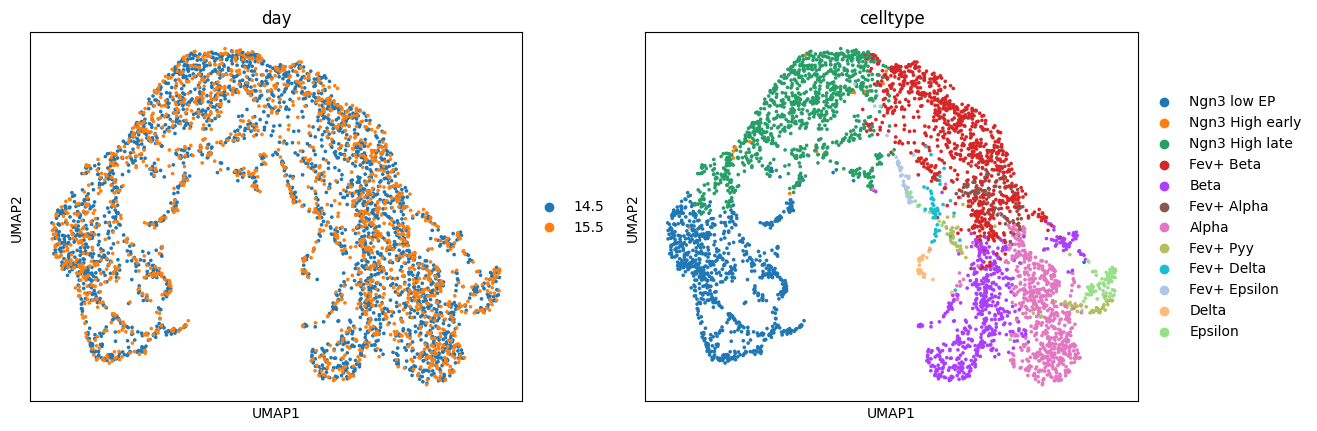

In [10]:
sc.pp.neighbors(cdata, use_rep="X_pca_result")
sc.tl.umap(cdata)
sc.pl.umap(cdata, color=["day", "celltype"])

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


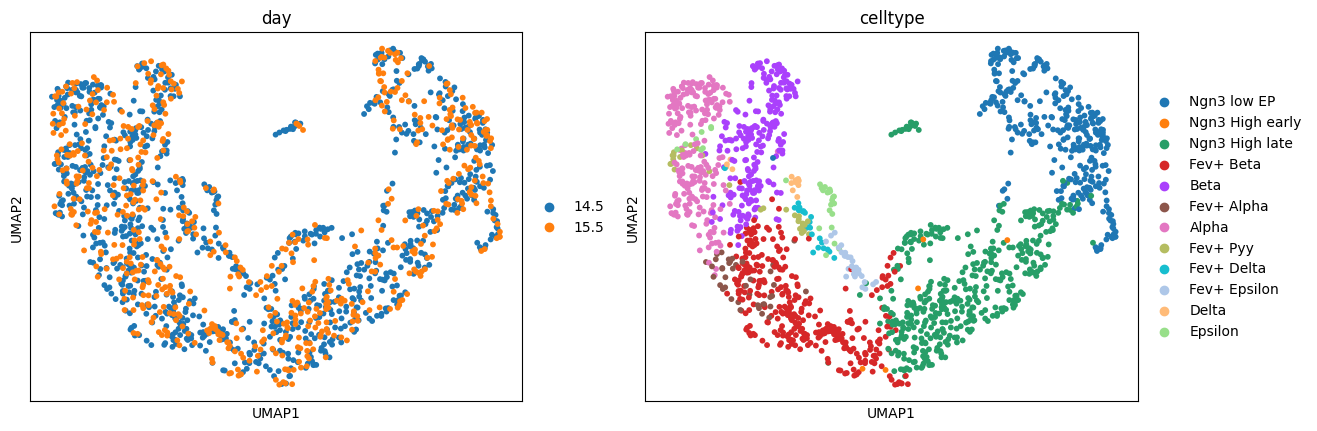

In [11]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")
sc.tl.umap(bdata)
sc.pl.umap(bdata, color=["day", "celltype"])

# Downstream analysis

In [12]:
from typing import Any, Iterable, Tuple

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from joblib import Parallel, delayed


def sample_velocities_from_transport_matrix(
    transport_matrix: np.ndarray, target_distribution: np.ndarray, n_samples: int
) -> np.ndarray:
    res = [None] * n_samples
    for i in range(n_samples):
        res[i] = target_distribution[
            jax.vmap(lambda x: jax.random.categorical(jax.random.PRNGKey(i), x))(jnp.log(transport_matrix))
        ]
    return jnp.asarray(res)


def compute_statistics_from_samples(
    samples: np.ndarray, split_to_k_batches: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    batch_size = samples.shape[0] // split_to_k_batches
    assert samples.shape[0] % split_to_k_batches == 0
    # samples is of shape (n_samples, n_cells, dim_velocity_vector)
    df = pd.DataFrame(index=cell_names)

    for i in range(split_to_k_batches):
        df[f"var_{i}"] = np.sum(np.var(samples[i * batch_size : (i + 1) * batch_size, ...], axis=0), axis=1)
        var_cols = [f"var_{i}" for i in range(split_to_k_batches)]

    df["var_of_variance"] = df[var_cols].var(axis=1)
    df["mean_of_variance"] = df[var_cols].mean(axis=1)
    return df


def compute_directional_statistics_from_samples(
    samples: np.ndarray, n_jobs: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    samples = np.asarray(samples)
    n_cells = len(cell_names)
    df = pd.DataFrame(index=cell_names)
    df["directional_variance"] = np.nan
    df["directional_difference"] = np.nan
    df["directional_cosine_sim_variance"] = np.nan
    df["directional_cosine_sim_difference"] = np.nan
    df["directional_cosine_sim_mean"] = np.nan
    results = Parallel(n_jobs=n_jobs, verbose=3)(
        delayed(_directional_statistics_per_cell)(samples[:, cell_index, :]) for cell_index in range(n_cells)
    )
    # cells by samples
    cosine_sims = np.stack([results[i][0] for i in range(n_cells)])
    df.loc[:, "directional_cosine_sim_variance"] = [results[i][1] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_difference"] = [results[i][2] for i in range(n_cells)]
    df.loc[:, "directional_variance"] = [results[i][3] for i in range(n_cells)]
    df.loc[:, "directional_difference"] = [results[i][4] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_mean"] = [results[i][5] for i in range(n_cells)]

    return df, cosine_sims


def _cosine_sim(v1: np.ndarray, v2: np.ndarray) -> np.ndarray:
    """Returns cosine similarity of the vectors."""
    v1_u = _centered_unit_vector(v1)
    v2_u = _centered_unit_vector(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)


def _directional_statistics_per_cell(
    tensor: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Internal function for parallelization.

    Parameters
    ----------
    tensor
        Shape of samples by genes for a given cell.
    """
    n_samples = tensor.shape[0]
    # over samples axis
    mean_velocity_of_cell = tensor.mean(0)
    cosine_sims = [_cosine_sim(tensor[i, :], mean_velocity_of_cell) for i in range(n_samples)]
    angle_samples = [np.arccos(el) for el in cosine_sims]
    return (
        cosine_sims,
        np.var(cosine_sims),
        np.percentile(cosine_sims, 95) - np.percentile(cosine_sims, 5),
        np.var(angle_samples),
        np.percentile(angle_samples, 95) - np.percentile(angle_samples, 5),
        np.mean(cosine_sims),
    )


def _centered_unit_vector(vector: np.ndarray) -> np.ndarray:
    """Returns the centered unit vector of the vector."""
    vector = vector - np.mean(vector)
    return vector / np.linalg.norm(vector)

In [13]:
cosine_vars_train = compute_directional_statistics_from_samples(push_train, 2, adata_source_train.obs_names)
cosine_vars_test = compute_directional_statistics_from_samples(push_test, 2, adata_source_test.obs_names)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done 2650 out of 2650 | elapsed:    6.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1054 out of 1054 | elapsed:    1.1s finished


In [14]:
bdata.obs["directional_variance"] = cosine_vars_test[0]["directional_variance"]
bdata.obs["directional_difference"] = cosine_vars_test[0]["directional_difference"]
bdata.obs["directional_cosine_sim_variance"] = cosine_vars_test[0]["directional_cosine_sim_variance"]

In [15]:
cdata.obs["directional_variance"] = cosine_vars_train[0]["directional_variance"]
cdata.obs["directional_difference"] = cosine_vars_train[0]["directional_difference"]
cdata.obs["directional_cosine_sim_variance"] = cosine_vars_train[0]["directional_cosine_sim_variance"]

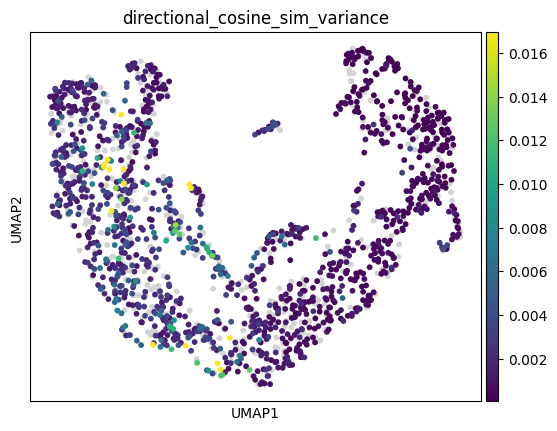

In [19]:
sc.pl.umap(bdata, color="directional_cosine_sim_variance", vmax="p99")

In [22]:
cdata.obs["celltype"].value_counts()

celltype
Ngn3 High late     997
Fev+ Beta          880
Ngn3 low EP        817
Alpha              637
Beta               565
Fev+ Alpha          97
Fev+ Pyy            88
Epsilon             87
Fev+ Delta          50
Fev+ Epsilon        49
Delta               33
Ngn3 High early     18
Name: count, dtype: int64

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


[Text(0, 0, 'Ngn3 low EP'),
 Text(1, 0, 'Ngn3 High early'),
 Text(2, 0, 'Ngn3 High late'),
 Text(3, 0, 'Fev+ Beta'),
 Text(4, 0, 'Beta'),
 Text(5, 0, 'Fev+ Alpha'),
 Text(6, 0, 'Alpha'),
 Text(7, 0, 'Fev+ Pyy'),
 Text(8, 0, 'Fev+ Delta'),
 Text(9, 0, 'Fev+ Epsilon'),
 Text(10, 0, 'Delta'),
 Text(11, 0, 'Epsilon')]

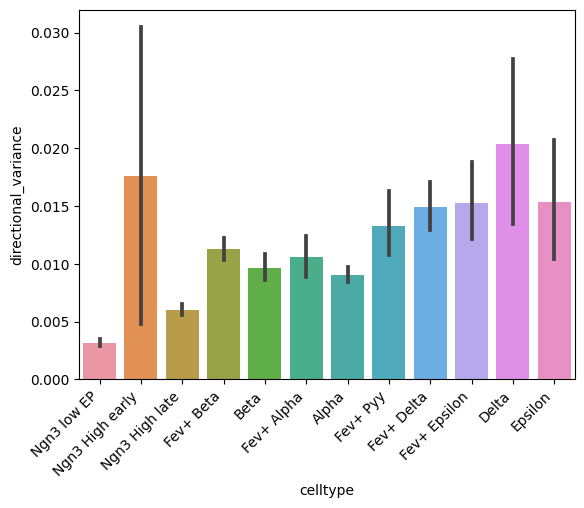

In [20]:
import seaborn as sns
g = sns.barplot(bdata.obs, x="celltype", y="directional_variance")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0, 0, 'Ngn3 low EP'),
 Text(1, 0, 'Ngn3 High early'),
 Text(2, 0, 'Ngn3 High late'),
 Text(3, 0, 'Fev+ Beta'),
 Text(4, 0, 'Beta'),
 Text(5, 0, 'Fev+ Alpha'),
 Text(6, 0, 'Alpha'),
 Text(7, 0, 'Fev+ Pyy'),
 Text(8, 0, 'Fev+ Delta'),
 Text(9, 0, 'Fev+ Epsilon'),
 Text(10, 0, 'Delta'),
 Text(11, 0, 'Epsilon')]

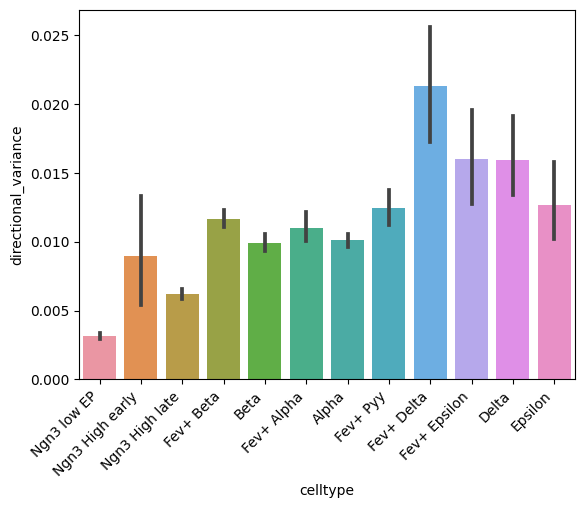

In [21]:
import seaborn as sns
g = sns.barplot(cdata.obs, x="celltype", y="directional_variance")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

In [ ]:
cdata.obs["cosine_var"] = cosine_vars_train["mean_of_variance"]
sc.pl.umap(adata, color="cosine_var", vmax="p90")

In [ ]:
df_vars =adata_early.obs[["celltype", "var_of_variance", "mean_of_variance"]].groupby("celltype").mean()

In [ ]:
df_vars =bdata.obs[["celltype", "var_of_variance", "mean_of_variance"]].groupby("celltype").mean()

In [ ]:
order_celltypes = ["Alpha", "Beta", "Delta", "Epsilon", "Fev+ Alpha", "Fev+ Beta", "Fev+ Delta", "Fev+", "Eps. progenitors", "Ngn3 high", "Ngn3 low"]
df_vars = df_vars.reindex(order_celltypes)

In [ ]:
#seaborn barplot

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


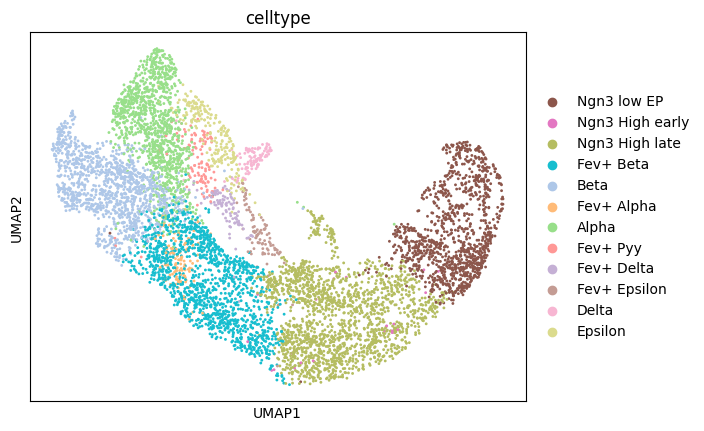

In [50]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="celltype")

In [53]:
adata.obs["celltype"].value_counts()

celltype
Ngn3 High late     1693
Fev+ Beta          1338
Beta               1177
Alpha              1119
Ngn3 low EP        1104
Epsilon             223
Fev+ Pyy            116
Fev+ Alpha          109
Delta               102
Fev+ Delta           99
Fev+ Epsilon         96
Ngn3 High early      21
Name: count, dtype: int64

In [16]:
from typing import Tuple, Callable, Union, List, Optional
import scipy.sparse as sp
import jax.numpy as jnp
import jax
import pandas as pd

def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  
        predicted_tgt_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 1,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None))
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        for index in range(0, len(predicted_tgt_cells), batch_size):
            _, indices = get_knn_fn(predicted_tgt_cells[index : index + batch_size], tgt_cells, k)
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(predicted_tgt_cells) - index)), min(k, len(tgt_cells)))
            )
        ri = jnp.concatenate(row_indices)
        ci = jnp.concatenate(column_indices)
        mat = np.zeros((len(ri), len(tgt_cells)))
        mat[ri,ci] = 1.0
        return mat

def aggregate_transport_matrix(adata_source, adata_target, tmat, aggregation_key = "celltype", forward = True):
    df_source = adata_source.obs[aggregation_key]
    df_target = adata_target.obs[aggregation_key]

    annotations_source = adata_source.obs[aggregation_key].cat.categories
    annotations_target = adata_target.obs[aggregation_key].cat.categories

    tm = pd.DataFrame(
        np.zeros((len(annotations_source), len(annotations_target))),
        index=annotations_source,
        columns=annotations_target,
    )
    
    for annotation_src in annotations_source:
        for annotation_tgt in annotations_target:
            tm.loc[annotation_src, annotation_tgt] = tmat[
                np.ix_((df_source == annotation_src).squeeze(), (df_target == annotation_tgt).squeeze())
            ].sum()
    return tm.div(tm.sum(axis=int(forward)), axis=int(not forward))

In [18]:
tm = project_transport_matrix(gex_predicted, target_test)
agg_tm = aggregate_transport_matrix(adata_source_test, adata_target_test, tm, forward=False)

In [19]:
agg_tm

,Tip,Acinar,Trunk,Ductal,Ngn3 low EP,Ngn3 High early,Ngn3 High late,Fev+ Beta,Beta,Fev+ Alpha,Alpha,Fev+ Pyy,Fev+ Delta,Fev+ Epsilon,Delta,Epsilon
Tip,0.84375,0.013959,0.000000,0.021858,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Acinar,0.00000,0.970812,0.048780,0.008197,0.010417,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Trunk,0.03125,0.002538,0.829268,0.035519,0.072917,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Ductal,0.12500,0.011421,0.073171,0.653005,0.463542,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Ngn3 low EP,0.00000,0.001269,0.048780,0.278689,0.427083,NaN,0.045643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Ngn3 High early,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,0.012448,0.004202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Ngn3 High late,0.00000,0.000000,0.000000,0.002732,0.026042,NaN,0.933610,0.088235,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.000,0.000000
Fev+ Beta,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,0.008299,0.815126,0.047244,0.363636,0.000000,0.047619,0.000000,0.000000,0.000,0.000000
Beta,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.033613,0.897638,0.030303,0.054422,0.047619,0.000000,0.055556,0.000,0.028571
Fev+ Alpha,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.046218,0.000000,0.454545,0.013605,0.047619,0.000000,0.000000,0.000,0.000000


In [21]:
agg_tm = aggregate_transport_matrix(adata_source_test, adata_target_test, tm, aggregation_key="lineage", forward=False)

In [22]:
agg_tm

,A,ED
A,0.979268,0.010142
ED,0.020732,0.989858


In [23]:
agg_tm = aggregate_transport_matrix(adata_source_test, adata_target_test, tm, aggregation_key="lineage", forward=True)
agg_tm

,A,ED
A,0.981663,0.018337
ED,0.011479,0.988521


In [24]:
full_test_data = jnp.concatenate((source_test, target_test), axis=0)
bdata.obs["left_marginals"] = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, x=full_test_data)
bdata.obs["right_marginals"] = otfm.state_xi.apply_fn({"params": otfm.state_xi.params}, x=full_test_data)

In [31]:
bdata.obs["left_marginals_source"] = bdata.obs.apply(lambda x: x["left_marginals"] if x["day"]=="14.5" else None, axis=1)
bdata.obs["left_marginals_target"] = bdata.obs.apply(lambda x: x["left_marginals"] if x["day"]=="15.5" else None, axis=1)
bdata.obs["right_marginals_target"] = bdata.obs.apply(lambda x: x["right_marginals"] if x["day"]=="15.5" else None, axis=1)
bdata.obs["right_marginals_source"] = bdata.obs.apply(lambda x: x["right_marginals"] if x["day"]=="14.5" else None, axis=1)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


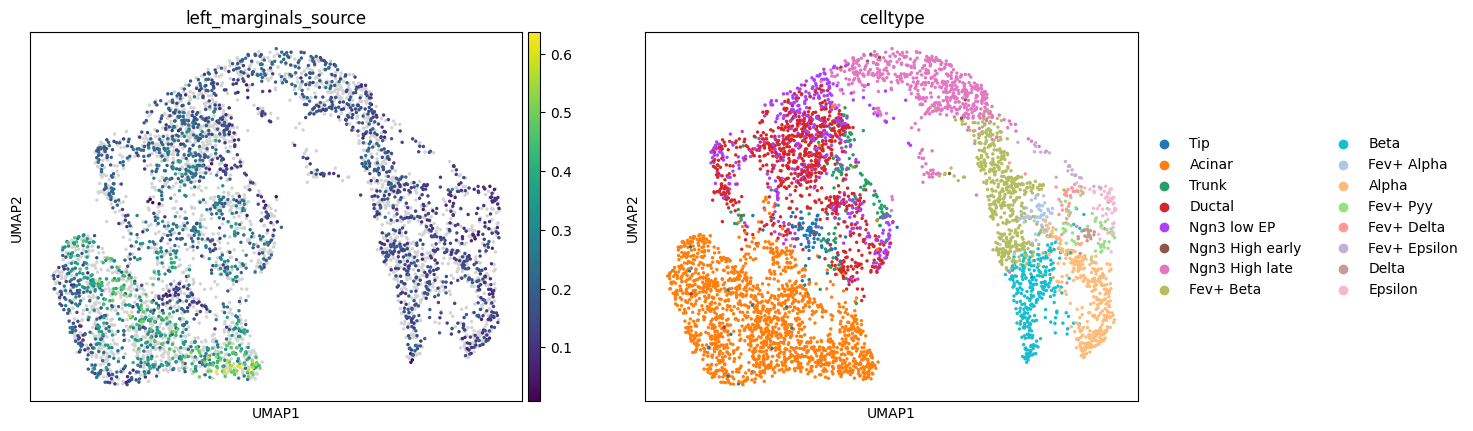

In [32]:
sc.pl.umap(bdata, color=["left_marginals_source", "celltype"])

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


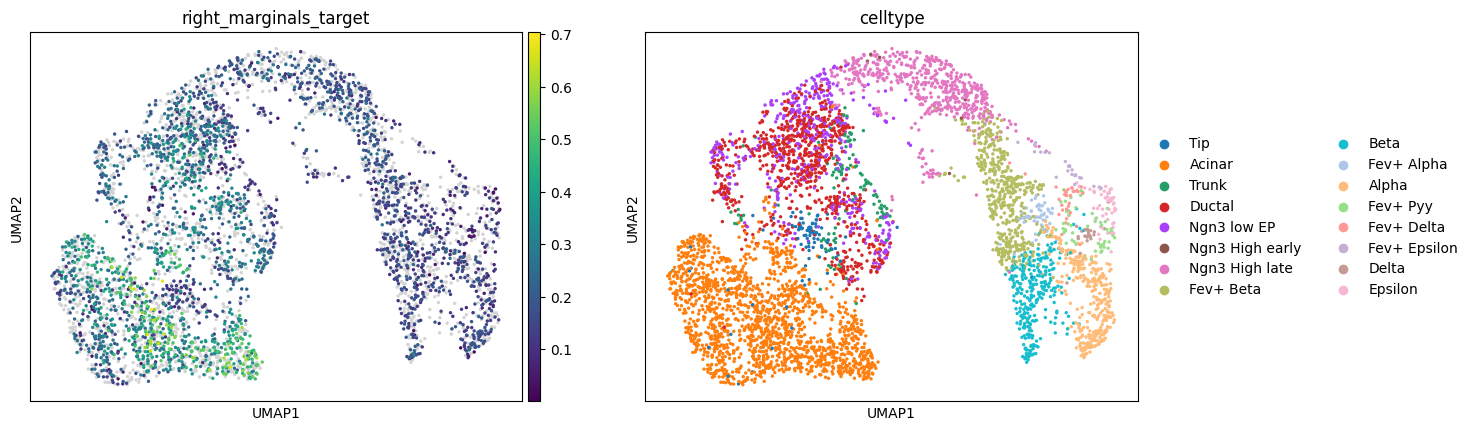

In [33]:
sc.pl.umap(bdata, color=["right_marginals_target", "celltype"])

In [38]:
bdata.obs[["left_marginals_source", "left_marginals_target", "right_marginals_source", "right_marginals_target", "lineage"]].groupby("lineage").mean()

,left_marginals_source,left_marginals_target,right_marginals_source,right_marginals_target
lineage,,,,
A,0.289817,0.278464,0.303219,0.318225
ED,0.165620,0.157191,0.164523,0.184243
